# Diabetes Hospitalizations

## Import Libraries

In [85]:
# Import standard analytics & statistics packages.

import numpy as np
import pandas as pd
import scipy.stats as scs
from collections import Counter
pd.set_option('display.max_columns', 120)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import models and samplers

from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import TomekLinks
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Import scalers and metrics

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, accuracy_score

import warnings
warnings.filterwarnings('ignore')

### Location of Dataset:

https://data.world/uci/diabetes-130-us-hospitals-for-years-1999-2008

### Article for which data was collected originally:
https://www.hindawi.com/journals/bmri/2014/781670/

## Import Data and Cleaning

In [2]:
df = pd.read_csv('https://query.data.world/s/fzhdybgova7pqh6amwfzrnhumdc26t')

Need to remove time-series elements from when the same patient visited several times. Kept the first entry and removed all others.

In [3]:
df.drop_duplicates(subset='patient_nbr', inplace=True) # 101,766 to 71,518 observations

Weight, Payer Code, and Medical Specialty were missing >50% of values.

In [4]:
df.drop(['encounter_id','patient_nbr','weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

Dropping missing values from Race column.

In [5]:
df = df[df.race != '?'] # about 1,000 obs
df = df[df.gender != 'Unknown/Invalid'] # 1 obs

Changed target variable to 0-2 for classes (No readmit, less than 30 days, more than 30 days).

In [6]:
df.readmitted.replace({'NO': 0, '<30': 1, '>30': 2}, inplace=True)

Parsing the ICD-9 medical billing codes, in order to grab just 250.xx coding diabetes.

In [7]:
df = df[pd.to_numeric(df['diag_1'], errors='coerce').notnull()] # Select non-null values after changing values to
df = df[pd.to_numeric(df['diag_2'], errors='coerce').notnull()] # numeric (removing V27/V57 entries and ?)
df = df[pd.to_numeric(df['diag_3'], errors='coerce').notnull()] #

df.diag_1 = df.diag_1.astype('float64') # Can now recast from Object to Float64 dtypes (want float to preserve
df.diag_2 = df.diag_2.astype('float64') # ICD-9 decimals as part of the billing code)
df.diag_3 = df.diag_3.astype('float64') #

In [8]:
df.gender = np.where(df.gender == 'Unknown/Invalid', 'Female', df.gender)

In [9]:
df.shape

(62754, 45)

## EDA

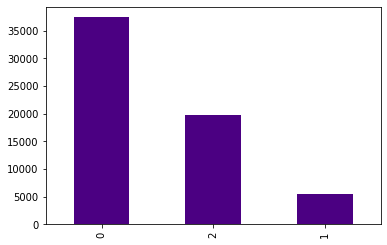

In [10]:
df.readmitted.value_counts().plot(kind='bar', color = 'indigo')

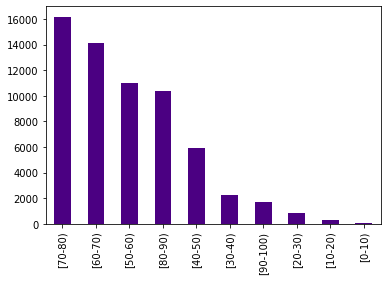

In [11]:
df.age.value_counts().plot(kind='bar',color='indigo')

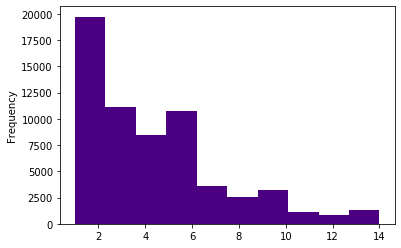

In [12]:
df.time_in_hospital.plot(kind='hist',color='indigo')

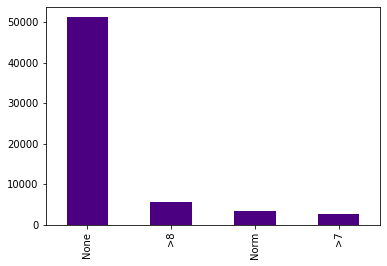

In [13]:
df.A1Cresult.value_counts().plot(kind='bar', color= 'indigo')

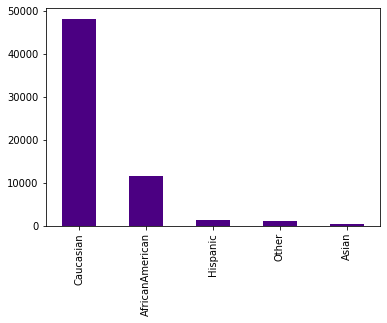

In [14]:
df.race.value_counts().plot(kind='bar', color='indigo')

In [16]:
a1c_prct = df.A1C_test.value_counts(normalize=True) * 100

In [17]:
a1c_prct.values

array([81.59479874, 18.40520126])

Text(0.9, 10, '18.4%')

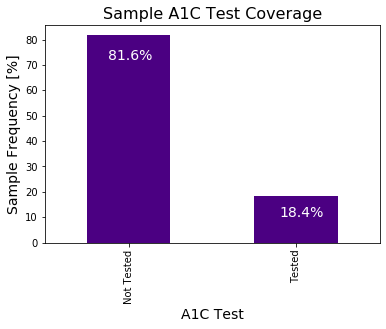

In [18]:
a1c_prct.plot(kind = 'bar', color = 'indigo')
plt.xlabel('A1C Test', fontsize=14)
plt.xticks([0,1,],labels= ['Not Tested', 'Tested'])
plt.ylabel('Sample Frequency [%]',fontsize=14)
plt.title('Sample A1C Test Coverage', fontsize=16)
plt.text(-0.125,72, str(round(a1c_prct.values[0],1)) + '%' ,fontsize=14, color = 'white')
plt.text(.90,10,str(round(a1c_prct.values[1],1)) + '%', fontsize=14, color = 'white')
#plt.savefig('A1C Test Coverage.png',dpi=150)

In [19]:
repl_dict = {0:'no readmission',
            1:'<30 days ',
            2:'>30 days'}

df['readd_cat'] = df['readmitted'].replace(repl_dict)

In [20]:
gender_prct = pd.DataFrame(df.groupby(by = 'gender')['readd_cat'].value_counts(normalize = True) * 100)

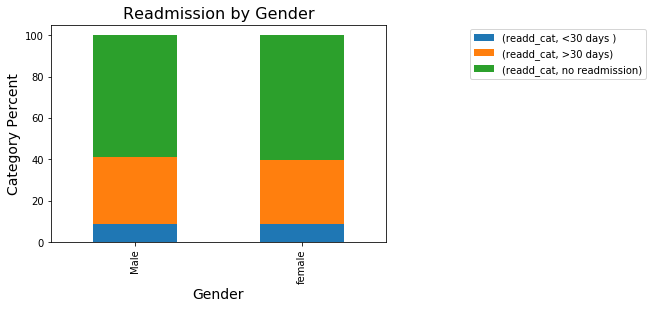

In [21]:
gender_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Gender', fontsize=14)
plt.xticks([0,1,],labels= ['Male', 'female'])
plt.ylabel('Category Percent',fontsize=14)
plt.title('Readmission by Gender', fontsize=16)
plt.legend(loc = (1.25,.75))
#plt.savefig('Readmission by Gender.png',dpi=150)

In [22]:
df[(df.gender == 'Male') & ((df.readmitted == 1) | (df.readmitted == 2))].readmitted.value_counts()

2    8986
1    2583
Name: readmitted, dtype: int64

In [23]:
df[(df.gender == 'Female') & ((df.readmitted == 1) | (df.readmitted == 2))].readmitted.value_counts()

2    10766
1     2992
Name: readmitted, dtype: int64

In [24]:
# is this similarity statistically significant or an effect of random sampling
# Test the statistical significance of observed means: perform two sample t-test of means

#H_0: readmission mean for males is the same as the readmitted average for females.

#H_1: readmission mean for males is not the same as the readmitted average for females.

male_readm_mean = 11,569 / len(df[ df.gender == 'Male'])
female_readm_mean = 13,758 /  len([df.gender == 'Female'])

scs.ttest_ind(male_readm_mean, female_readm_mean)

## p-value >> alpha of 0.05. fail to reject the null hypothesis. conclusion: population readmission means based on gender are different.

Ttest_indResult(statistic=-1.0199973379685168, pvalue=0.4150293666038609)

In [25]:
age_prct = pd.DataFrame(df.groupby(by = 'age')['readd_cat'].value_counts(normalize = True) * 100)

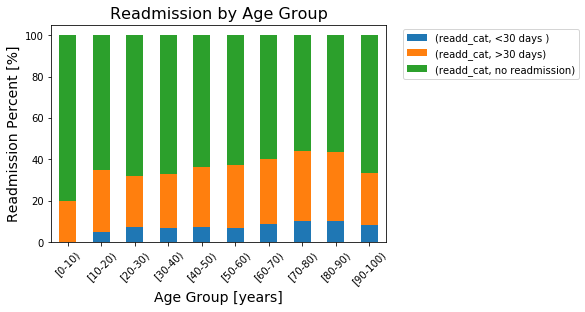

In [26]:
age_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Age Group [years]', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Readmission Percent [%]',fontsize=14)
plt.title('Readmission by Age Group', fontsize=16)
plt.legend(loc = (1.05,.75))
#plt.savefig('Readmission by Age Group',dpi=150)

In [27]:
race_prct = pd.DataFrame(df.groupby(by = 'race')['readd_cat'].value_counts(normalize = True) * 100)

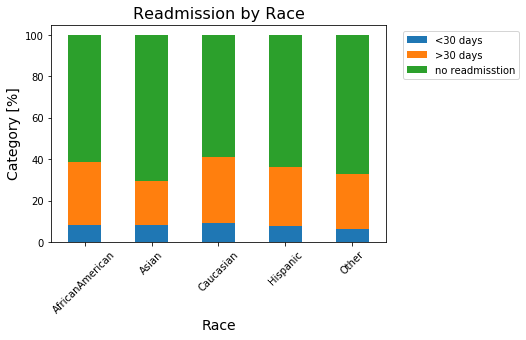

In [28]:
race_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Race', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Category [%]',fontsize=14)
plt.title('Readmission by Race', fontsize=16)
plt.legend(loc = (1.05,.75),labels = ['<30 days','>30 days','no readmisstion'])
#plt.savefig('Readmission by Race',dpi=150)

In [29]:
# RUN A1C_TEST CELL IN FEATURE ENGINEERING BEFORE MAKING EXECUTING NEXT 2 CELLS.

race_test_prct = pd.DataFrame(df.groupby(by = 'race')['A1C_test'].value_counts(normalize=True))

In [30]:
race_test_prct

A1C_test
race            A1C_test          
AfricanAmerican 0         0.798388
                1         0.201612
Asian           0         0.779510
                1         0.220490
Caucasian       0         0.823517
                1         0.176483
Hispanic        0         0.737657
                1         0.262343
Other           0         0.780603
                1         0.219397

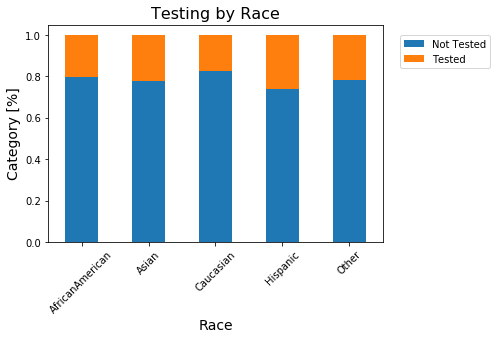

In [31]:
race_test_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Race', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Category [%]',fontsize=14)
plt.title('Testing by Race', fontsize=16)
plt.legend(loc = (1.05,.8), labels = ['Not Tested', 'Tested'])
#plt.savefig('Readmission by Days Admitted',dpi=150)

In [32]:
tih_prct = pd.DataFrame(df.groupby(by = 'time_in_hospital')['readd_cat'].value_counts(normalize = True) * 100)

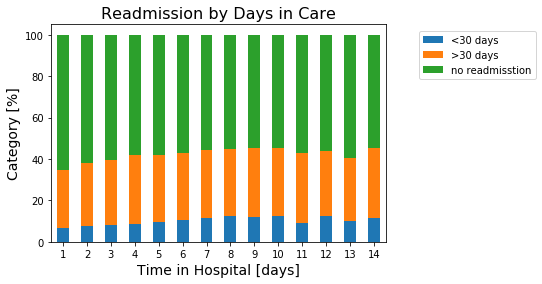

In [34]:
tih_prct.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Time in Hospital [days]', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('Category [%]',fontsize=14)
plt.title('Readmission by Days in Care', fontsize=16)
plt.legend(loc = (1.10,.75), labels = ['<30 days','>30 days','no readmisstion'])
#plt.savefig('Readmission by Days Admitted',dpi=150)

In [35]:
df = df.drop("readd_cat", axis=1)

## Feature Engineering

Was the patient given a A1C test at all?

In [15]:
df['A1C_test'] = np.where(df.A1Cresult == 'None', 0, 1)

Was the patient's meds changed during the hospitalization?

In [36]:
df.change = np.where(df.change == 'No', 0, 1)

Was the patient tested and meds changed?

In [37]:
df['A1C_test_and_changed'] = np.where((df.change == 1) & (df.A1C_test == 1), 1, 0)

From domain knowledge, patients are readmitted at different rates based on their age brackets.

In [38]:
conditions = [
    (df.age ==  '[0-10)') | (df.age == '[10-20)') | (df.age == '[20-30)'),
    (df.age == '[30-40)') | (df.age == '[40-50)') | (df.age == '[50-60)'),
    (df.age == '[60-70)') | (df.age == '[70-80)') | (df.age == '[80-90)') | (df.age == '[90-100')]

choices = [
    '[0-30)',
    '[30-60]',
    '[60-100)']

In [39]:
df['binned_age'] = np.select(conditions, choices, default=np.nan)

In [40]:
df = df[df.binned_age != 'nan']

In [41]:
df.drop(['age'], axis=1, inplace=True) # Dropping for correlation

Is diabetes one of the three primary diagnoses for the hospitalization?

In [42]:
df['diabetes_as_diag_1'] = np.where((df.diag_1 >= 250) & (df.diag_1 <251), 1, 0)
df['diabetes_as_diag_2'] = np.where((df.diag_2 >= 250) & (df.diag_2 <251), 1, 0)
df['diabetes_as_diag_3'] = np.where((df.diag_3 >= 250) & (df.diag_3 <251), 1, 0)

In [43]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True) # Dropping for correlation

In [44]:
meds_to_remove = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'tolbutamide', 
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
            'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
            'metformin-rosiglitazone', 'metformin-pioglitazone']
df.drop(meds_to_remove, axis=1, inplace=True)

In [45]:
df.shape

(61025, 28)

In [46]:
df

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted,A1C_test,A1C_test_and_changed,binned_age,diabetes_as_diag_1,diabetes_as_diag_2,diabetes_as_diag_3
1,Caucasian,Female,1,1,7,3,59,0,18,0,0,0,9,None,None,No,No,No,Up,1,Yes,2,0,0,[0-30),0,1,0
3,Caucasian,Male,1,1,7,2,44,1,16,0,0,0,7,None,None,No,No,No,Up,1,Yes,0,0,0,[30-60],0,1,0
4,Caucasian,Male,1,1,7,1,51,0,8,0,0,0,5,None,None,No,Steady,No,Steady,1,Yes,0,0,0,[30-60],0,0,1
5,Caucasian,Male,2,1,2,3,31,6,16,0,0,0,9,None,None,No,No,No,Steady,0,Yes,2,0,0,[30-60],0,0,1
7,Caucasian,Male,1,1,7,5,73,0,12,0,0,0,8,None,None,No,No,Steady,No,0,Yes,2,0,0,[60-100),0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,1,1,7,9,50,2,33,0,0,0,9,None,>7,No,No,Up,Steady,1,Yes,2,1,1,[60-100),0,0,1
101755,Other,Female,1,1,7,14,73,6,26,0,1,0,9,None,>8,No,Steady,No,Up,1,Yes,2,1,1,[30-60],0,0,0
101756,Other,Female,1,1,7,2,46,6,17,1,1,1,9,None,None,No,No,No,Steady,0,Yes,2,0,0,[60-100),0,0,0
101758,Caucasian,Female,1,1,7,5,76,1,22,0,1,0,9,None,None,No,No,No,Up,1,Yes,0,0,0,[60-100),0,0,0


## Feature Selection

In [47]:
X = df.drop('readmitted', axis = 1)
y = df.readmitted

### Generating Polynomical/Interaction Features

In [48]:
continuous_variables = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
categorical_variables = [x for x in X.columns if x not in continuous_variables]

In [49]:
df_cont = X[continuous_variables]
df_cate = X[categorical_variables]

Generating polynomial and interaction features for continuous variables.

In [50]:
poly_cont = PolynomialFeatures(2)
poly_df_cont_data = poly_cont.fit_transform(df_cont)
poly_df_cont_cols = poly_cont.get_feature_names(df_cont.columns)
poly_df_cont = pd.DataFrame(poly_df_cont_data, columns=poly_df_cont_cols) # 45 features

In [51]:
poly_df_cont.shape

(61025, 45)

Generating interaction features for categorical variables.

In [52]:
dummy_df_cate = pd.get_dummies(df_cate)

In [53]:
poly_cate = PolynomialFeatures(interaction_only=True)
poly_df_cate_data = poly_cate.fit_transform(dummy_df_cate)
poly_df_cate_cols = poly_cate.get_feature_names(dummy_df_cate.columns)
poly_df_cate = pd.DataFrame(poly_df_cate_data, columns=poly_df_cate_cols) # 1,036 features

In [54]:
poly_df_cate.shape

(61025, 1036)

Concatenating our cont and cate features back together.

In [55]:
df_all = pd.concat([poly_df_cont, poly_df_cate], axis = 1) # 1,081 features total

In [56]:
df_all.shape

(61025, 1081)

### Train Test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_all, y, random_state=30)
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (45768, 1081) Target:  (45768,)
Training set - Features:  (15257, 1081) Target:  (15257,)


Scaling our data: fit to the training set then apply to both train and test sets.

In [58]:
#### Try dtc w/ and w/out scaling... shouldnt make a difference.

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

### Removing Correlated Features

In [58]:
corr_matrix = X_train.corr().abs()

In [59]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [60]:
correlated = [column for column in upper.columns if any(upper[column] > 0.75)]

X_train.drop(columns=correlated, inplace=True)
X_test.drop(columns=correlated, inplace=True)

## Modeling

In [61]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='weighted')))

#### Baseline Logisitic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [137]:
logreg = LogisticRegression(random_state=30, max_iter=1000)
model_log = logreg.fit(X_train, y_train)

In [138]:
y_pred = model_log.predict(X_test)

In [139]:
print_metrics(y_pred, y_test)

Precision Score: 0.8586873999295855
Recall Score: 0.6010355902208823
Accuracy Score: 0.6010355902208823
F1 Score: 0.6909935803465734


#### Baseline Dummy Classifier

In [71]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

In [72]:
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))

Test Accuracy score:  0.5926459985580389


In [74]:
print('Test Recall score: ', recall_score(y_test, dummy_pred, average='weighted'))

Test Recall score:  0.5926459985580389


#### Baseline Decision Tree

In [75]:
clf = DecisionTreeClassifier()
model_dt = clf.fit(X_train,y_train)

y_pred_dt_test = model_dt.predict(X_test)

print_metrics(y_test,y_pred_dt_test)

Precision Score: 0.49562436958706607
Recall Score: 0.4894802385790129
Accuracy Score: 0.4894802385790129
F1 Score: 0.49245900695517947


In [76]:
clf_balanced = DecisionTreeClassifier(class_weight = 'balanced')
model_dt1 = clf_balanced.fit(X_train,y_train)

y_pred_dt1_test = model_dt1.predict(X_test)

print_metrics(y_test,y_pred_dt1_test)

Precision Score: 0.49267525498971715
Recall Score: 0.4860064232811169
Accuracy Score: 0.4860064232811169
F1 Score: 0.48924444406941336


#### Handling Class Imbalance:

**SMOTE:**

In [77]:
from imblearn.over_sampling import SMOTE

In [78]:
sm = SMOTE(sampling_strategy='minority', random_state=23)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [79]:
smote_dtc = DecisionTreeClassifier()

In [80]:
smote_dtc.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [81]:
smote_pred = smote_dtc.predict(X_test)

In [82]:
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred, labels = [0,1,2],average='weighted'))

Test Accuracy score:  0.4919708986039195
Test F1 score:  0.4950556930341407


**Tomek links:**

In [86]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 23257, 2: 10849, 1: 4097})


In [89]:
tl.sample_indices_

array([    1,     2,     3, ..., 45765, 45766, 45767])

In [90]:
len(X_train), len(X_res)

(45768, 38203)

In [92]:
tomek_dtc = DecisionTreeClassifier()
tomek_dtc.fit(X_res, y_res)
tomek_pred = tomek_dtc.predict(X_test)

In [93]:
print('Test Accuracy score: ', accuracy_score(y_test, tomek_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, tomek_pred, labels = [0,1,2],average='weighted'))

Test Accuracy score:  0.4934128596709707
Test F1 score:  0.496769147732738


#### GridSearch Decision Tree - baseline

In [94]:
# Import Grid search
from sklearn.model_selection import GridSearchCV

In [95]:
param_grid = {
    'max_depth': range(1,31,1),
    'criterion': ['gini','entropy'],
    'splitter' : ['best','random']
}

In [96]:
scoring = {'f1':'f1_weighted', 'Accuracy': 'accuracy'}

In [97]:
dtc_grid = DecisionTreeClassifier(class_weight='balanced')
grid_tree = GridSearchCV(dtc_grid, param_grid, cv=5, scoring=scoring, refit= 'f1', verbose=1)

In [98]:
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 28.0min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 31),
                         'splitter': ['best', 'random']},
             refit='f1', scoring={'Accuracy': 'accuracy', 'f1': 'f1_weighted'},
             verbose=1)

In [99]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.4828747306448743
{'criterion': 'gini', 'max_depth': 28, 'splitter': 'random'}
DecisionTreeClassifier(class_weight='balanced', max_depth=28, splitter='random')


In [100]:
y_pred = grid_tree.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred,average = 'weighted'))

F1: 0.4795097212175504


In [101]:
print('Test Accuracy score: ', accuracy_score(y_test, y_pred))

Test Accuracy score:  0.46005112407419546


#### GridSearch Decision Tree - Tomek

In [103]:
dtc_grid_tl = DecisionTreeClassifier(class_weight='balanced')
grid_tree_tl = GridSearchCV(dtc_grid_tl, param_grid, cv=5, scoring=scoring, refit= 'f1', verbose=1)

In [104]:
grid_tree_tl.fit(X_res,y_res)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 22.9min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 31),
                         'splitter': ['best', 'random']},
             refit='f1', scoring={'Accuracy': 'accuracy', 'f1': 'f1_weighted'},
             verbose=1)

In [105]:
print(grid_tree_tl.best_score_)

print(grid_tree_tl.best_params_)

print(grid_tree_tl.best_estimator_)

0.5001404576266262
{'criterion': 'gini', 'max_depth': 30, 'splitter': 'best'}
DecisionTreeClassifier(class_weight='balanced', max_depth=30)


In [106]:
y_pred_tl = grid_tree.best_estimator_.predict(X_test)

In [107]:
print("F1:",metrics.f1_score(y_test, y_pred_tl, average = 'weighted'))

F1: 0.4795097212175504
